Sequential time: 0.0010018358693847655 for array size 100 x 100
Parrallel time: 0.0019979486928710937 for array size 100 x 100 with 2=CPUS
Parrallel time: 0.002000571297241211 for array size 100 x 100 with 4=CPUS
Parrallel time: 0.000999928520751953 for array size 100 x 100 with 8=CPUS
Parrallel time: 0.0019991407857666015 for array size 100 x 100 with 10=CPUS
Parrallel time: 0.004003525780273438 for array size 100 x 100 with 16=CPUS
Sequential time: 0.005001069115234375 for array size 200 x 200
Parrallel time: 0.002001048134399414 for array size 200 x 200 with 2=CPUS
Parrallel time: 0.0049977312551269535 for array size 200 x 200 with 4=CPUS
Parrallel time: 0.001999379204345703 for array size 200 x 200 with 8=CPUS
Parrallel time: 0.0029990683065185546 for array size 200 x 200 with 10=CPUS
Parrallel time: 0.00400233368737793 for array size 200 x 200 with 16=CPUS
Sequential time: 0.10999822716577148 for array size 400 x 400
Parrallel time: 0.024003983543945312 for array size 400 x 400 wi

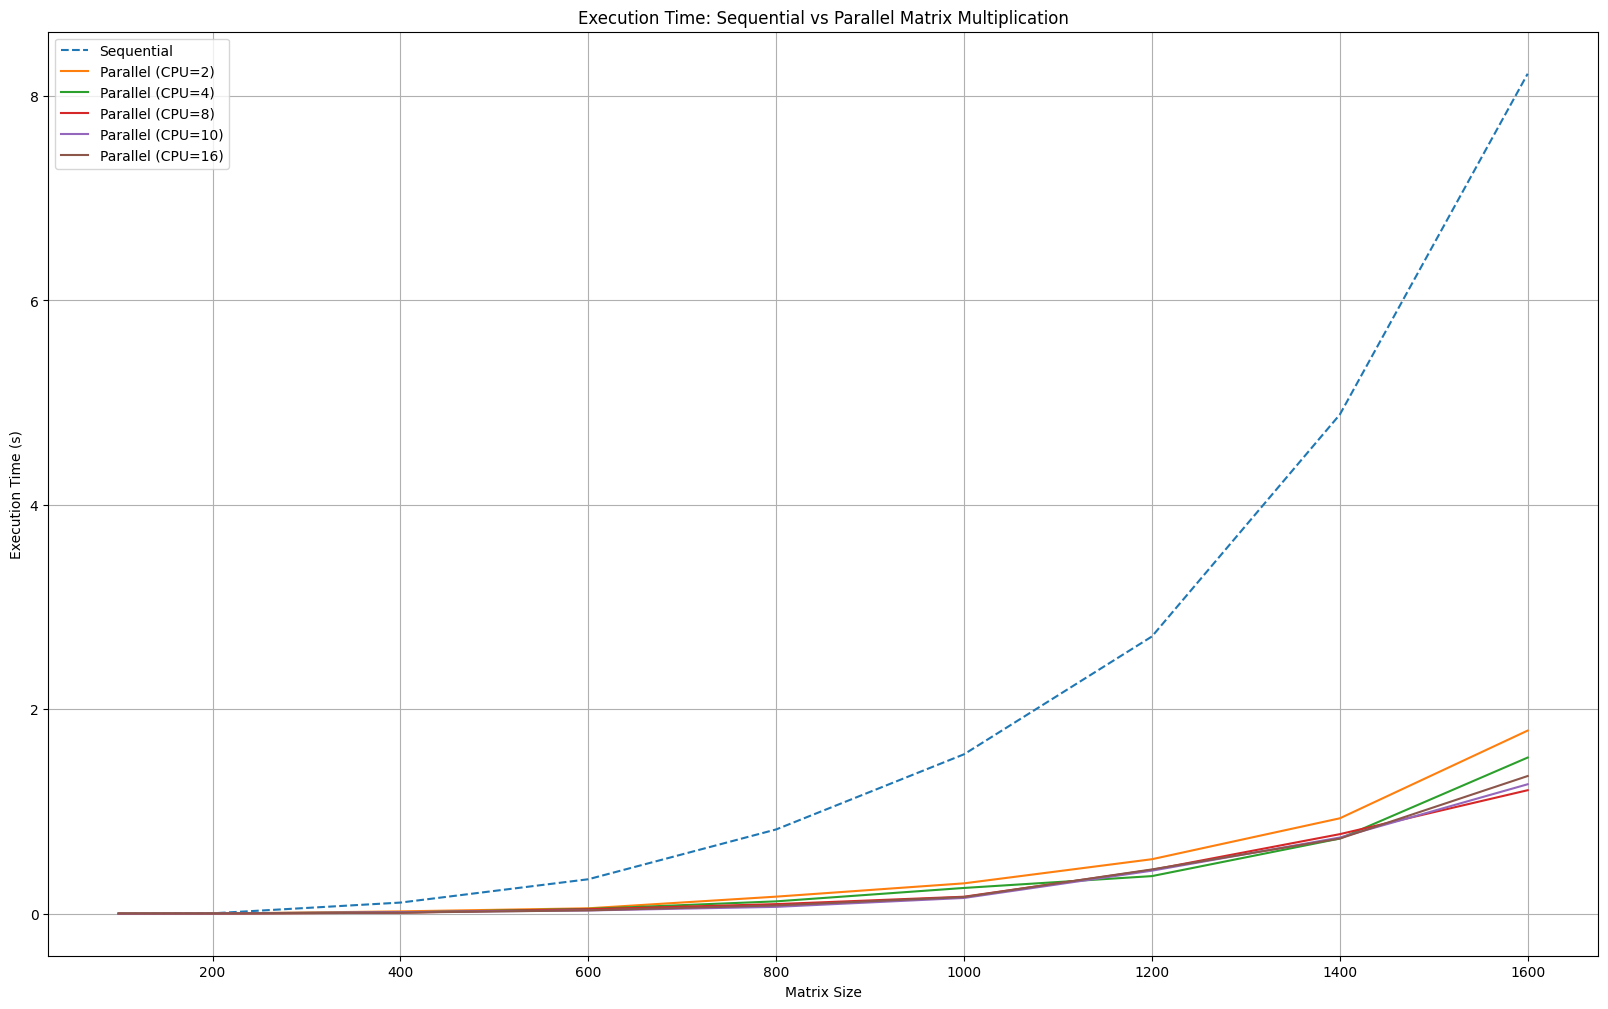

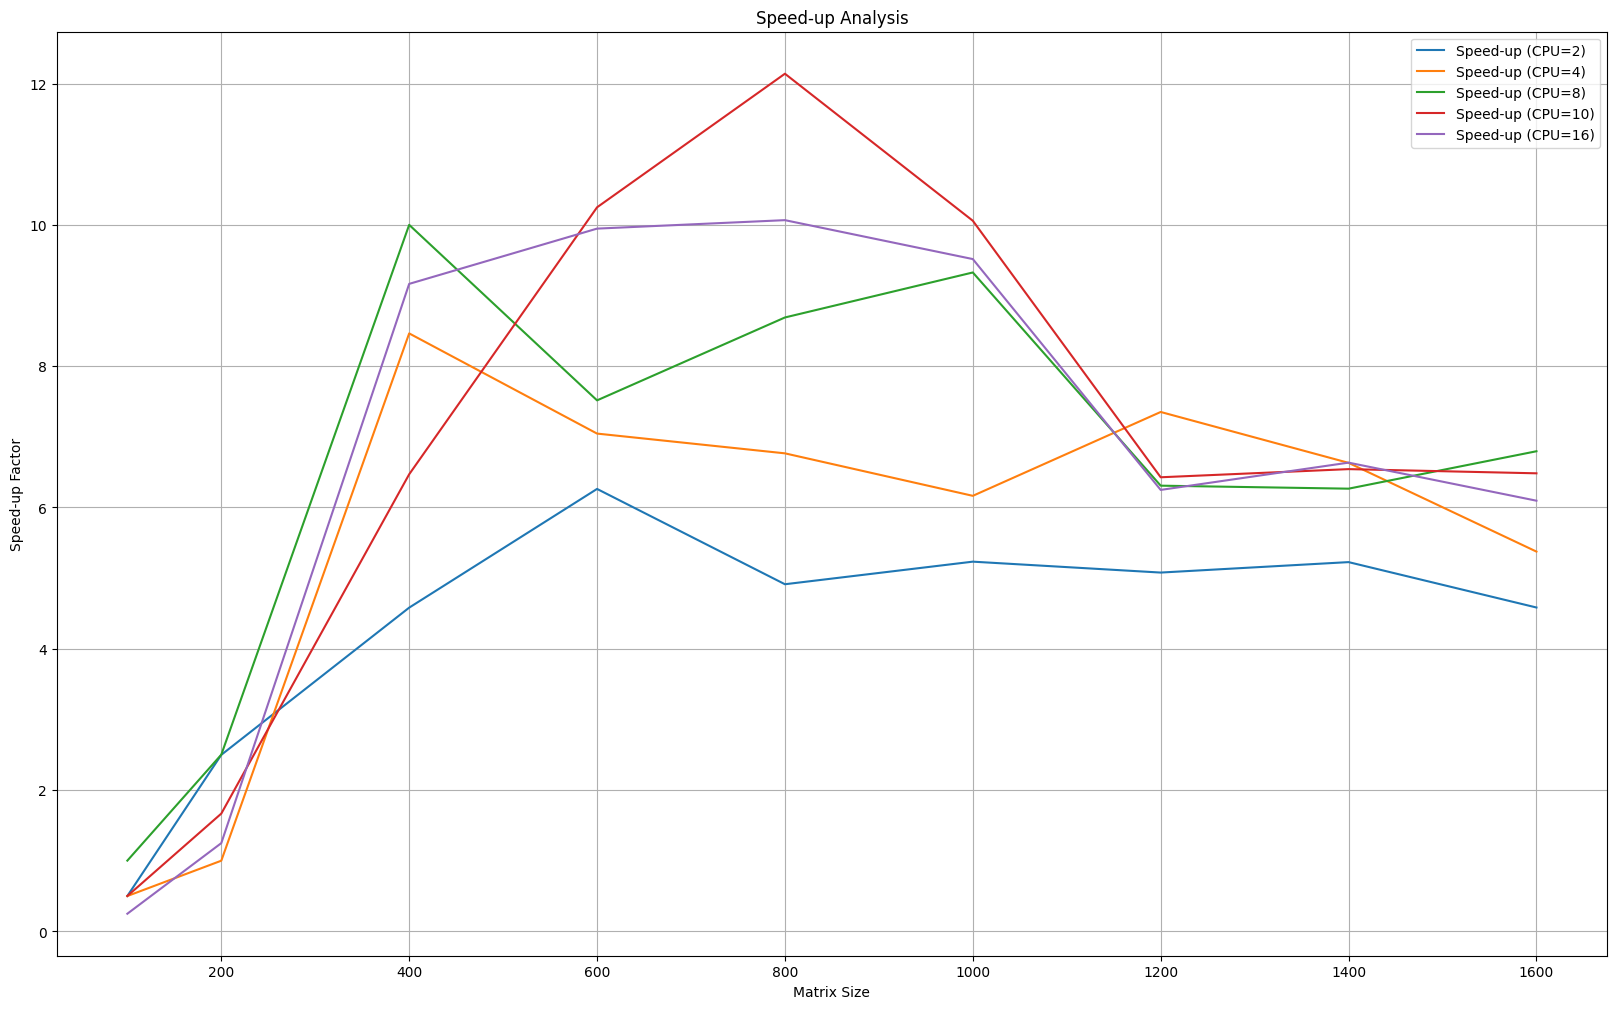

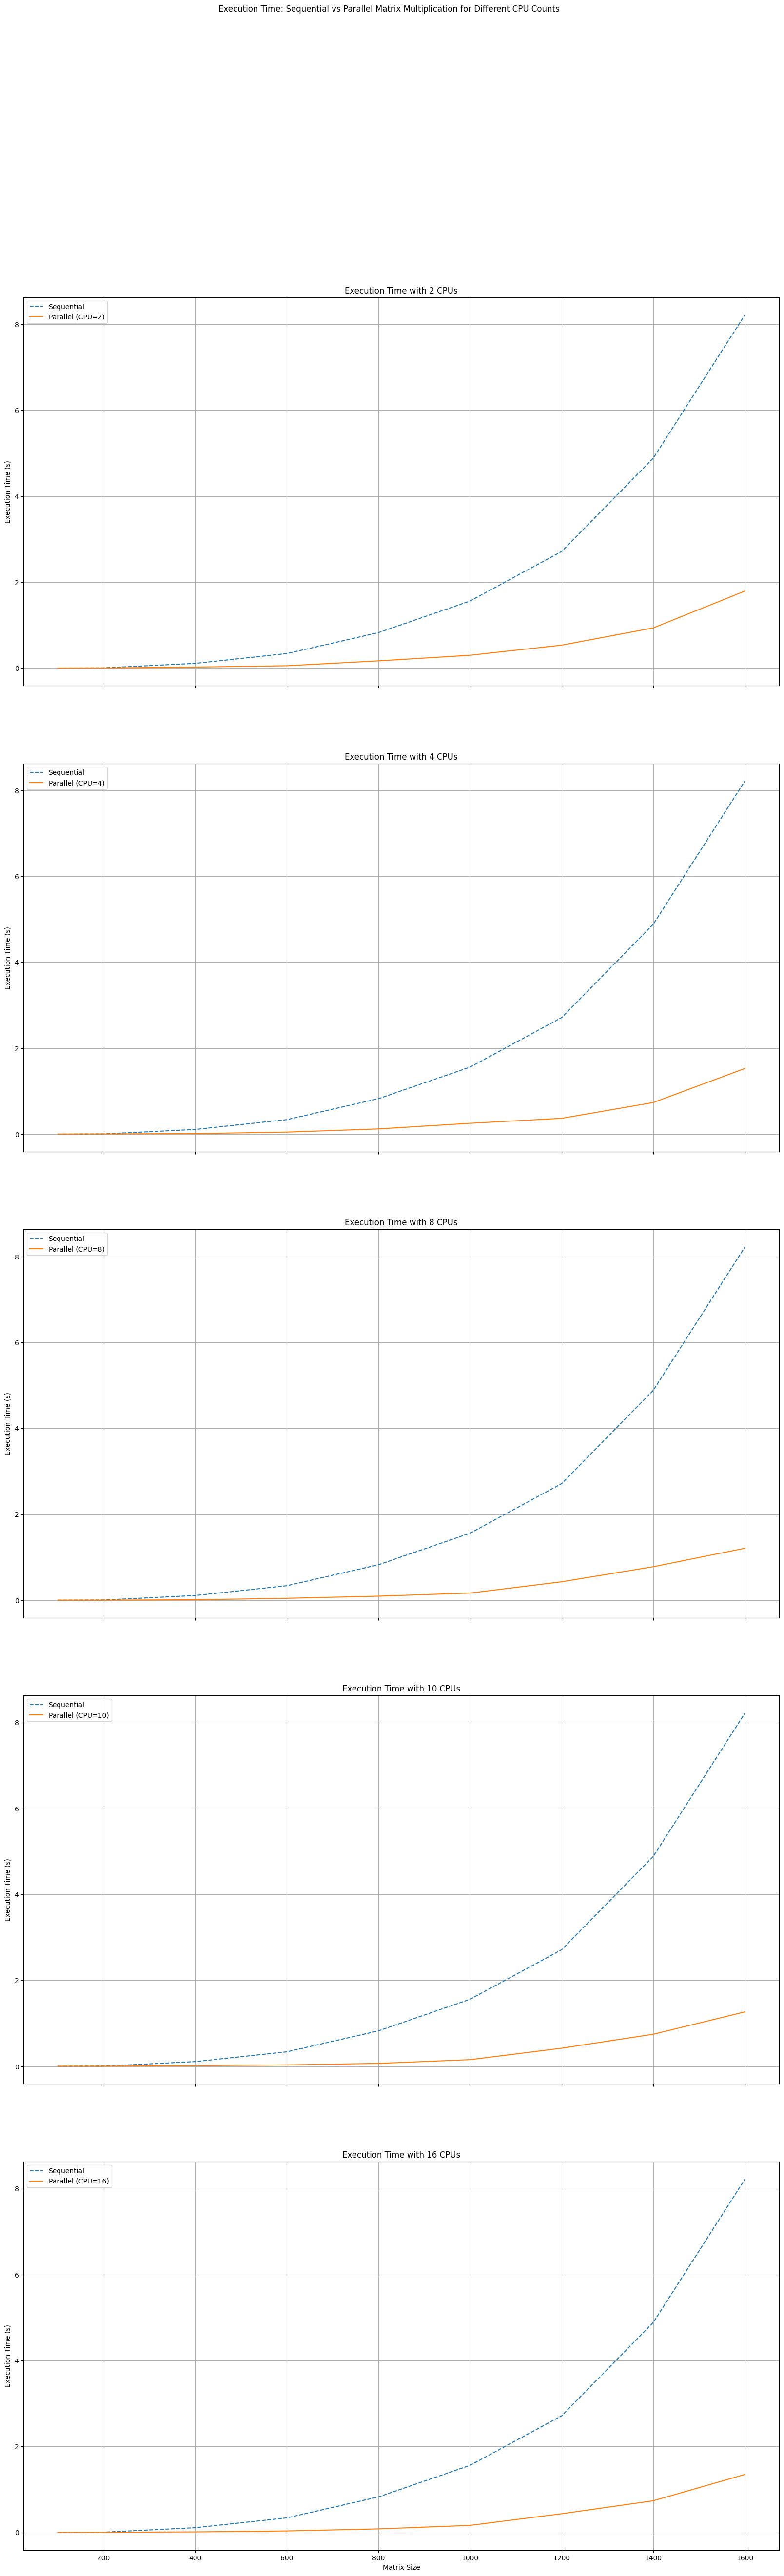

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool
import os
import numpy as np
from numpy.testing import assert_array_equal
import threading
import time
from numpy.testing import assert_array_equal, assert_allclose
import pandas as pd

num_threads = os.cpu_count()


def sequential_matrix_multiplication(A, B):
    """
    Performs matrix multiplication sequentially.
    """
    return np.matmul(A, B)


def compute_dot_product(a, b, out):
  

    out[:] = np.dot(a, b)  # less efficient because the output is stored in a temporary array?

def split_matrix_into_blocks(arr, rows_per_block, cols_per_block):
 
    h, w = arr.shape
    n, m = h // rows_per_block, w // cols_per_block
    return arr.reshape(rows_per_block, n, cols_per_block, m).swapaxes(1, 2)
def mydot(a, b, rows_per_cpu, cols_per_cpu, dot_func=compute_dot_product):

    total_cpus = rows_per_cpu * cols_per_cpu

    out = np.empty((a.shape[0], b.shape[1]), dtype=a.dtype)


    out_blocks = split_matrix_into_blocks(out, rows_per_cpu, cols_per_cpu)
    a_blocks = split_matrix_into_blocks(a, rows_per_cpu, 1)
    b_blocks = split_matrix_into_blocks(b, 1, cols_per_cpu)

    cpu_threads = []
    for i in range(rows_per_cpu):
        for j in range(cols_per_cpu):
            thread = threading.Thread(target=dot_func, 
                                      args=(a_blocks[i, 0, :, :], 
                                            b_blocks[0, j, :, :], 
                                            out_blocks[i, j, :, :]))
            thread.start()
            cpu_threads.append(thread)

    for thread in cpu_threads:
        thread.join()

    return out


def parallel_matrix_multiplication(A, B, num_cpus):
 
    if num_cpus == 2:
        return mydot(A,B,1,2)
    elif num_cpus == 4:
        return mydot(A,B,2,2)
    elif num_cpus == 6:
        return mydot(A,B,2,3)
    elif num_cpus == 8:
        return mydot(A,B,2,4) 
    elif num_cpus == 10:
        return mydot(A,B,2,5)
    elif num_cpus == 12:
        return mydot(A,B,2,5)
    elif num_cpus == 16:
        return mydot(A,B,4,4)
    else:
        print("error")
        pass

matrix_sizes = [100,200,400,600,800,1000,1200,1400,1600]
num_cpus = [2, 4, 8,10, 16]  # Adjust based on your machine's capability
data = []
sequential_times = np.zeros((len(matrix_sizes), 1))
parallel_times = np.zeros((len(matrix_sizes), len(num_cpus)))
speed_ups = np.zeros((len(matrix_sizes), len(num_cpus)))


epsilon = 1e-9  # Small number to prevent division by zero

# Measure execution times and calculate speed-up
for i, size in enumerate(matrix_sizes):
    A = np.random.randn(size, size).astype(int)
    B = np.random.randn(size, size).astype(int)
    
    # Sequential execution

 
    start_time = time.time()
    C_sequential = sequential_matrix_multiplication(A, B)
    sequential_time = time.time() - start_time + epsilon  # Add epsilon to avoid division by zero
    sequential_times[i] = sequential_time
    print(f'Sequential time: { sequential_time} for array size {size} x {size}')
    data.append({'size': size, 'cpus': 1, 'time': sequential_time})

    # Parallel execution for different CPU counts
    for j, cpu_count in enumerate(num_cpus):

        start_time = time.time()
        C_parallel = parallel_matrix_multiplication(A, B, cpu_count)
        parallel_time = time.time() - start_time + epsilon  # Add epsilon to avoid division by zero
        parallel_times[i][j] = parallel_time
        print(f'Parrallel time: { parallel_time} for array size {size} x {size} with {cpu_count}=CPUS')
        
        speed_ups[i][j] = sequential_times[i][0] / (parallel_time + epsilon)
        data.append({'size': size, 'cpus': cpu_count, 'time': parallel_time})

# Plotting execution time
plt.figure(figsize=(20, 12))
plt.plot(matrix_sizes, sequential_times[:, 0], label='Sequential', linestyle='--')
for j, cpu_count in enumerate(num_cpus):
    plt.plot(matrix_sizes, parallel_times[:, j], label=f'Parallel (CPU={cpu_count})')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time: Sequential vs Parallel Matrix Multiplication')
plt.legend()
plt.grid(True)
plt.show()

# Plotting speed-up
plt.figure(figsize=(20, 12))
for j, cpu_count in enumerate(num_cpus):
    plt.plot(matrix_sizes, speed_ups[:, j], label=f'Speed-up (CPU={cpu_count})')
plt.xlabel('Matrix Size')
plt.ylabel('Speed-up Factor')
plt.title('Speed-up Analysis')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(len(num_cpus), 1, figsize=(20, 12 * len(num_cpus)), sharex=True)

for j, cpu_count in enumerate(num_cpus):
    axs[j].plot(matrix_sizes, sequential_times[:, 0], label='Sequential', linestyle='--')
    axs[j].plot(matrix_sizes, parallel_times[:, j], label=f'Parallel (CPU={cpu_count})')
    axs[j].set_title(f'Execution Time with {cpu_count} CPUs')
    axs[j].set_ylabel('Execution Time (s)')
    axs[j].grid(True)
    axs[j].legend()

plt.xlabel('Matrix Size')
fig.suptitle('Execution Time: Sequential vs Parallel Matrix Multiplication for Different CPU Counts')
plt.show()

df = pd.DataFrame(data)




   size  cpus      time
0   100     1  0.001002
1   100     2  0.001998
2   100     4  0.002001
3   100     8  0.001000
4   100    10  0.001999
Columns in df: Index(['size', 'cpus', 'time', 'time_seq', 'speedup'], dtype='object')


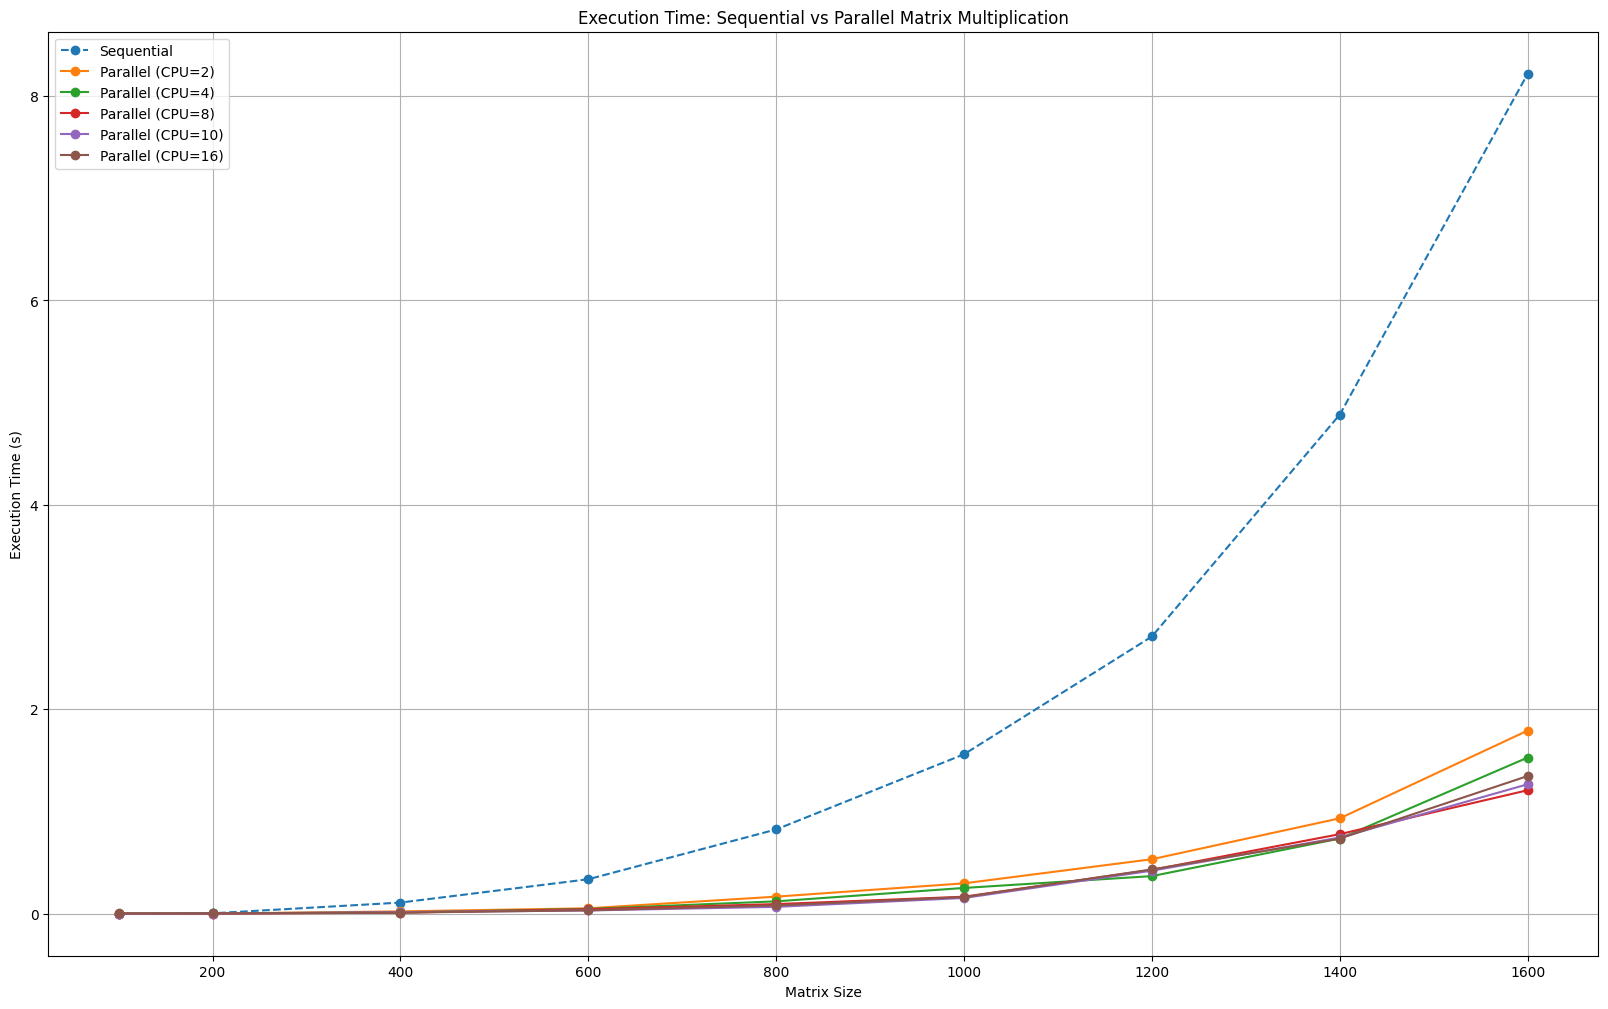

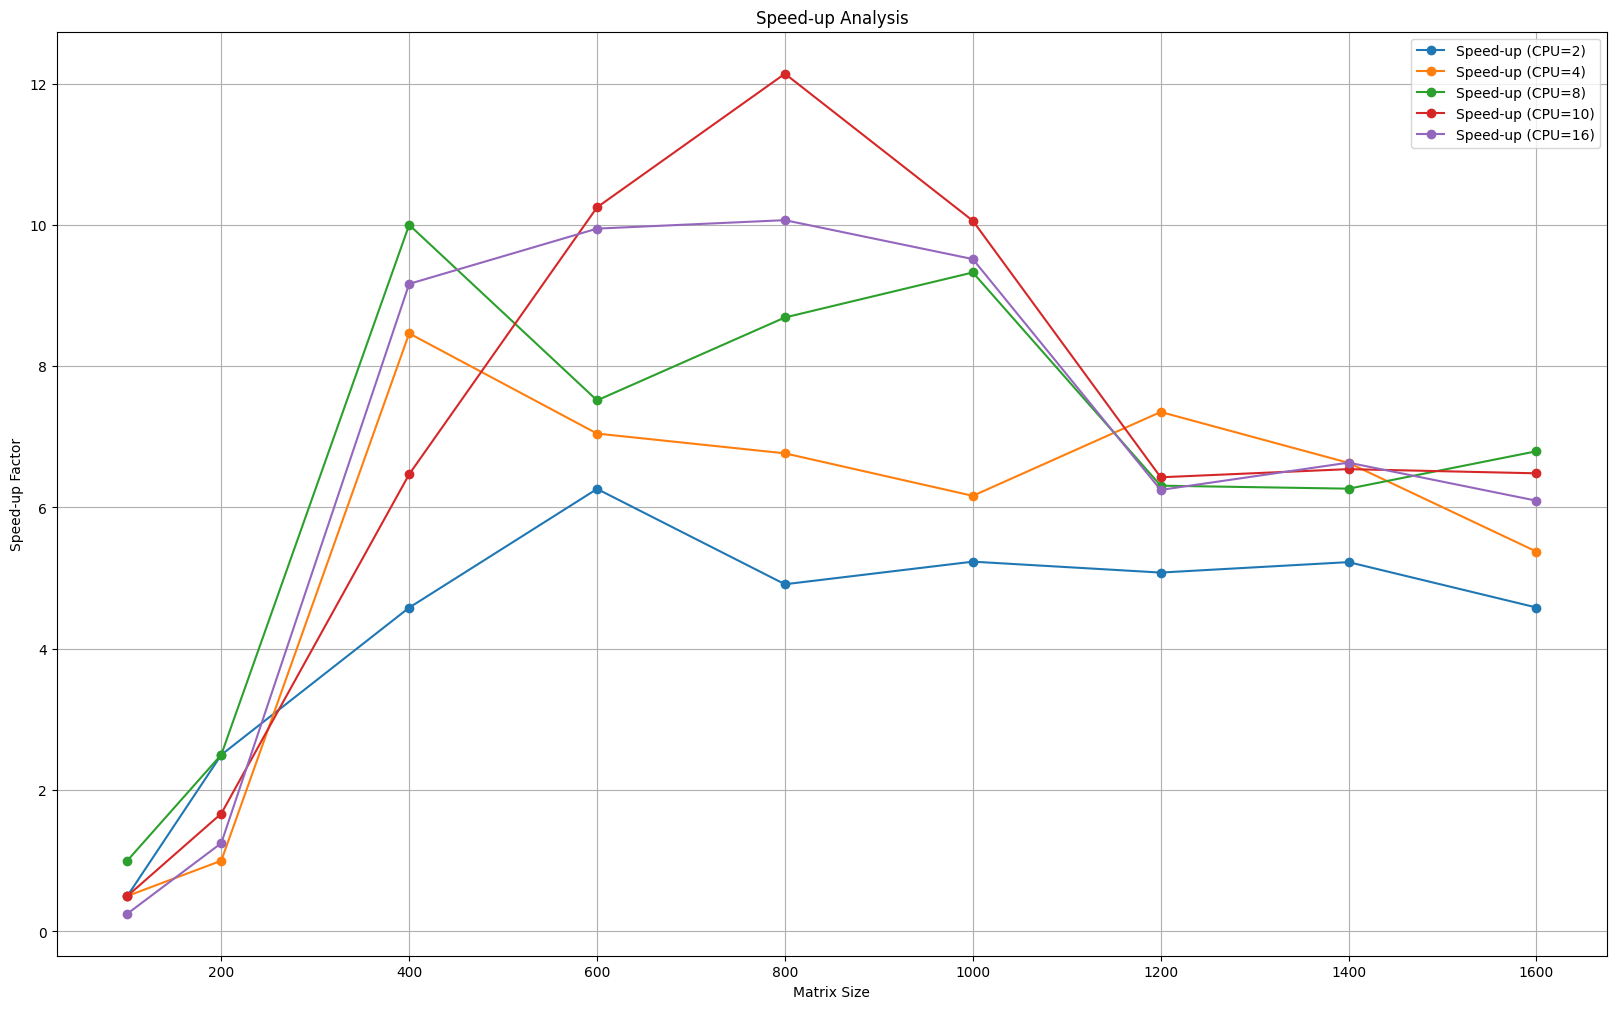

In [20]:

# Display the first few rows to verify it's loaded correctly
print(df.head())
# Separate the sequential times
sequential_times = df[df['cpus'] == 1]

# Merge the sequential times back to calculate speedup
df = df.merge(sequential_times[['size', 'time']], on='size', suffixes=('', '_seq'))

# Calculate speedup
df['speedup'] = df['time_seq'] / df['time']
import matplotlib.pyplot as plt

print("Columns in df:", df.columns)
# Unique matrix sizes and CPU counts
matrix_sizes = sorted(df['size'].unique())
cpu_counts = sorted(df['cpus'].unique())

# Plotting execution time
plt.figure(figsize=(20, 12))
for cpu in cpu_counts:
    if cpu == 1:
        plt.plot(matrix_sizes, df[df['cpus'] == cpu].groupby('size')['time'].mean(), label=f'Sequential', linestyle='--', marker='o')
    else:
        plt.plot(matrix_sizes, df[df['cpus'] == cpu].groupby('size')['time'].mean(), label=f'Parallel (CPU={cpu})', marker='o')

plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time: Sequential vs Parallel Matrix Multiplication')
plt.legend()
plt.grid(True)
plt.show()

# Plotting speed-up
plt.figure(figsize=(20, 12))
for cpu in cpu_counts:
    if cpu > 1:
        plt.plot(matrix_sizes, df[df['cpus'] == cpu].groupby('size')['speedup'].mean(), label=f'Speed-up (CPU={cpu})', marker='o')

plt.xlabel('Matrix Size')
plt.ylabel('Speed-up Factor')
plt.title('Speed-up Analysis')
plt.legend()
plt.grid(True)
plt.show()


In [22]:

print("Columns in df:", df.columns)
print(df)


Columns in df: Index(['size', 'cpus', 'time', 'time_seq', 'speedup'], dtype='object')
    size  cpus      time  time_seq    speedup
0    100     1  0.001002  0.001002   1.000000
1    100     2  0.001998  0.001002   0.501432
2    100     4  0.002001  0.001002   0.500775
3    100     8  0.001000  0.001002   1.001907
4    100    10  0.001999  0.001002   0.501133
5    100    16  0.004004  0.001002   0.250238
6    200     1  0.005001  0.005001   1.000000
7    200     2  0.002001  0.005001   2.499225
8    200     4  0.004998  0.005001   1.000668
9    200     8  0.001999  0.005001   2.501311
10   200    10  0.002999  0.005001   1.667541
11   200    16  0.004002  0.005001   1.249538
12   400     1  0.109998  0.109998   1.000000
13   400     2  0.024004  0.109998   4.582499
14   400     4  0.012996  0.109998   8.464188
15   400     8  0.010999  0.109998  10.000780
16   400    10  0.017001  0.109998   6.470045
17   400    16  0.012002  0.109998   9.165179
18   600     1  0.338212  0.338212   1.0

In [28]:


# Iterate through unique CPU counts
for cpu in sorted(df['cpus'].unique()):
    subset = df[df['cpus'] == cpu]
    min_speedup = subset['speedup'].min()
    max_speedup = subset['speedup'].max()
    min_size = subset[subset['speedup'] == min_speedup]['size'].iloc[0]
    max_size = subset[subset['speedup'] == max_speedup]['size'].iloc[0]

    print(f"For {cpu} CPUs:")
    print(f"• Speedup ranges from approximately {min_speedup:.2f} (for a {min_size}x{min_size} matrix) to {max_speedup:.2f} (for a {max_size}x{max_size} matrix).\n")


For 1 CPUs:
• Speedup ranges from approximately 1.00 (for a 100x100 matrix) to 1.00 (for a 100x100 matrix).

For 2 CPUs:
• Speedup ranges from approximately 0.50 (for a 100x100 matrix) to 6.26 (for a 600x600 matrix).

For 4 CPUs:
• Speedup ranges from approximately 0.50 (for a 100x100 matrix) to 8.46 (for a 400x400 matrix).

For 8 CPUs:
• Speedup ranges from approximately 1.00 (for a 100x100 matrix) to 10.00 (for a 400x400 matrix).

For 10 CPUs:
• Speedup ranges from approximately 0.50 (for a 100x100 matrix) to 12.14 (for a 800x800 matrix).

For 16 CPUs:
• Speedup ranges from approximately 0.25 (for a 100x100 matrix) to 10.07 (for a 800x800 matrix).



In [29]:
bins = [0, 500, 1000, 2000, 3000, 4000, 5000]  # Define your bins
labels = ['0-500', '500-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000']  # Labels for bins
df['size_category'] = pd.cut(df['size'], bins=bins, labels=labels, include_lowest=True)
cpu_counts = sorted(df['cpus'].unique())

# Iterate through each combination of CPU count and size category
for cpu in cpu_counts:
    print(f"For {cpu} CPUs:")
    for category in labels:
        subset = df[(df['cpus'] == cpu) & (df['size_category'] == category)]
        
        if subset.empty:
            continue  # Skip if there are no entries for this combination
        
        min_speedup = subset['speedup'].min()
        max_speedup = subset['speedup'].max()
        min_size = subset[subset['speedup'] == min_speedup]['size'].iloc[0]
        max_size = subset[subset['speedup'] == max_speedup]['size'].iloc[0]

        print(f"• In {category} matrix size range, speedup ranges from approximately {min_speedup:.2f} (for a {min_size}x{min_size} matrix) to {max_speedup:.2f} (for a {max_size}x{max_size} matrix).")

    print("\n")  # Add extra newline for readability between CPU counts


For 1 CPUs:
• In 0-500 matrix size range, speedup ranges from approximately 1.00 (for a 100x100 matrix) to 1.00 (for a 100x100 matrix).
• In 500-1000 matrix size range, speedup ranges from approximately 1.00 (for a 600x600 matrix) to 1.00 (for a 600x600 matrix).
• In 1000-2000 matrix size range, speedup ranges from approximately 1.00 (for a 1200x1200 matrix) to 1.00 (for a 1200x1200 matrix).


For 2 CPUs:
• In 0-500 matrix size range, speedup ranges from approximately 0.50 (for a 100x100 matrix) to 4.58 (for a 400x400 matrix).
• In 500-1000 matrix size range, speedup ranges from approximately 4.91 (for a 800x800 matrix) to 6.26 (for a 600x600 matrix).
• In 1000-2000 matrix size range, speedup ranges from approximately 4.58 (for a 1600x1600 matrix) to 5.23 (for a 1400x1400 matrix).


For 4 CPUs:
• In 0-500 matrix size range, speedup ranges from approximately 0.50 (for a 100x100 matrix) to 8.46 (for a 400x400 matrix).
• In 500-1000 matrix size range, speedup ranges from approximately 6.1